# MAPseq Data Analysis

In this notebook, we will take the combined bulk RNAseq from all MAPseq target areas. 

## Imports

In [2]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

from mapseq.core import *
from mapseq.barcode import *
from mapseq.utils import *
from mapseq.bowtie import run_bowtie, make_bowtie_df, make_adjacency_df

logging.getLogger().setLevel(logging.DEBUG)

print("Done")

Done


## Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the barcode (SSI) sequences for different target areas, and a standard sample info Excel spreadsheet. 


In [3]:
cp = get_default_config()
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M229/Mseq229_sampleinfo.xlsx')
barcodes = os.path.expanduser('~/project/mapseq/M229/barcode_v2.txt')
outdir = os.path.expanduser('~/project/mapseq/M229/out')
infiles = [
    os.path.expanduser('~/project/mapseq/M229/fastq/M229_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M229/fastq/M229_S1_R2_001.fastq.gz')
          ]
print("Done")

Done


In [4]:
sampdf = load_sample_info(cp, sampleinfo)
# extract list of actually used primers.
rtlist = list(sampdf.rtprimer.dropna())
rtlist = [int(x) for x in rtlist]
rtlist = [ f'BC{x}' for x in rtlist]
rtlist
# make barcode handler objects
bcolist = load_barcodes(cp, barcodes, labels=rtlist, outdir=outdir)
print(len(bcolist))
sampdf = sampdf[sampdf['rtprimer'].notna()]
sampdf.rtprimer = sampdf.rtprimer.astype(int)
of = f'{outdir}/sampleinfo.tsv'
sampdf.to_csv(of, sep='\t')
rtlist
sampdf

2023-10-24 10:58:12,200 (UTC) [ WARNING ] core.py:859 root.load_sample_info(): no column samplename, required. Creating...
2023-10-24 10:58:12,202 (UTC) [ WARNING ] core.py:859 root.load_sample_info(): no column region, required. Creating...
/Users/jhover/miniconda3/envs/mapseq/lib/python3.9/site-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
2023-10-24 10:58:12,216 (UTC) [ ERROR ] core.py:65 root.fix_columns_str(): error while handling region 
2023-10-24 10:58:12,227 (UTC) [ WARNING ] core.py:66 root.fix_columns_str(): Traceback (most recent call last):
  File "/Users/jhover/miniconda3/envs/mapseq/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/

ValueError: invalid literal for int() with base 10: ''

In [47]:
# handle all the input. usually takes ~ minutes
# M229. 297M reads. 
process_fastq_pair(cp, infiles[0], infiles[1], bcolist, outdir=outdir, force=False)
os.listdir(outdir)

2023-05-30 14:22:03,241 (UTC) [ INFO ] core.py:489 root.check_output(): /Users/jhover/project/mapseq/M229/out/BC281.fasta doesn't exist. output_exists=False
2023-05-30 14:22:03,242 (UTC) [ INFO ] core.py:489 root.check_output(): /Users/jhover/project/mapseq/M229/out/BC282.fasta doesn't exist. output_exists=False
2023-05-30 14:22:03,243 (UTC) [ INFO ] core.py:489 root.check_output(): /Users/jhover/project/mapseq/M229/out/BC283.fasta doesn't exist. output_exists=False
2023-05-30 14:22:03,244 (UTC) [ INFO ] core.py:489 root.check_output(): /Users/jhover/project/mapseq/M229/out/BC284.fasta doesn't exist. output_exists=False
2023-05-30 14:22:03,245 (UTC) [ INFO ] core.py:489 root.check_output(): /Users/jhover/project/mapseq/M229/out/BC285.fasta doesn't exist. output_exists=False
2023-05-30 14:22:03,246 (UTC) [ INFO ] core.py:489 root.check_output(): /Users/jhover/project/mapseq/M229/out/BC287.fasta doesn't exist. output_exists=False
2023-05-30 14:22:03,247 (UTC) [ INFO ] core.py:489 root.ch

2023-05-30 15:23:16,899 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 53000000 reads. matched=42224745 unmatched=10775255
2023-05-30 15:24:22,204 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 54000000 reads. matched=43022538 unmatched=10977462
2023-05-30 15:25:27,588 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 55000000 reads. matched=43818118 unmatched=11181882
2023-05-30 15:26:33,273 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 56000000 reads. matched=44612193 unmatched=11387807
2023-05-30 15:27:39,071 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 57000000 reads. matched=45405847 unmatched=11594153
2023-05-30 15:28:44,470 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 58000000 reads. matched=46198880 unmatched=11801120
2023-05-30 15:29:50,227 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 59000000 reads. matched=46990583 unmatched=12009417
2023-05-30 15:30:57,188 (UTC) [ IN

2023-05-30 16:32:33,802 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 113000000 reads. matched=89544513 unmatched=23455487
2023-05-30 16:33:39,250 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 114000000 reads. matched=90328075 unmatched=23671925
2023-05-30 16:34:44,863 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 115000000 reads. matched=91108435 unmatched=23891565
2023-05-30 16:35:50,394 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 116000000 reads. matched=91885837 unmatched=24114163
2023-05-30 16:36:55,703 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 117000000 reads. matched=92662230 unmatched=24337770
2023-05-30 16:38:01,071 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 118000000 reads. matched=93438696 unmatched=24561304
2023-05-30 16:39:06,420 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 119000000 reads. matched=94216716 unmatched=24783284
2023-05-30 16:40:11,887 (UT

2023-05-30 17:36:55,363 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 172000000 reads. matched=136112238 unmatched=35887762
2023-05-30 17:38:00,375 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 173000000 reads. matched=136906579 unmatched=36093421
2023-05-30 17:39:05,572 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 174000000 reads. matched=137702925 unmatched=36297075
2023-05-30 17:40:10,958 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 175000000 reads. matched=138499679 unmatched=36500321
2023-05-30 17:41:16,240 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 176000000 reads. matched=139299002 unmatched=36700998
2023-05-30 17:42:21,475 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 177000000 reads. matched=140099249 unmatched=36900751
2023-05-30 17:43:26,551 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 178000000 reads. matched=140894319 unmatched=37105681
2023-05-30 17:44:31,

2023-05-30 20:45:07,618 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 231000000 reads. matched=183082867 unmatched=47917133
2023-05-30 20:46:13,591 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 232000000 reads. matched=183866684 unmatched=48133316
2023-05-30 20:47:19,742 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 233000000 reads. matched=184655324 unmatched=48344676
2023-05-30 20:48:25,385 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 234000000 reads. matched=185441155 unmatched=48558845
2023-05-30 20:49:30,953 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 235000000 reads. matched=186225255 unmatched=48774745
2023-05-30 20:50:36,908 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 236000000 reads. matched=187007871 unmatched=48992129
2023-05-30 20:51:43,092 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 237000000 reads. matched=187798211 unmatched=49201789
2023-05-30 20:52:48,

2023-05-30 21:49:52,019 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 290000000 reads. matched=229572032 unmatched=60427968
2023-05-30 21:50:58,010 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 291000000 reads. matched=230350185 unmatched=60649815
2023-05-30 21:52:03,722 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 292000000 reads. matched=231128849 unmatched=60871151
2023-05-30 21:53:09,467 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 293000000 reads. matched=231909640 unmatched=61090360
2023-05-30 21:54:15,219 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 294000000 reads. matched=232696773 unmatched=61303227
2023-05-30 21:55:20,968 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 295000000 reads. matched=233483004 unmatched=61516996
2023-05-30 21:56:26,661 (UTC) [ INFO ] core.py:562 root.process_fastq_pair(): handled 296000000 reads. matched=234266491 unmatched=61733509
2023-05-30 21:57:32,

['SSI285.real.tsv',
 'SSI284.real.tsv',
 'unmatched.fasta',
 'BC283.fasta',
 'BC281.fasta',
 'SSI283.spike.tsv',
 'SSI287.lone.tsv',
 'SSI288.spike.tsv',
 'BC285.fasta',
 'SSI288.all.tsv',
 'merge_areas.config.202305252144.txt',
 'SSI285.spike.tsv',
 'BC287.fasta',
 'SSI281.all.tsv',
 'process_ssifasta.config.202305081548.txt',
 'seq',
 'SSI283.all.tsv',
 'BC282.fasta',
 'SSI282.spike.tsv',
 'SSI282.real.tsv',
 'SSI283.real.tsv',
 'SSI282.all.tsv',
 'old',
 'SSI288.real.tsv',
 'process_ssifasta.config.202305081559.txt',
 'SSI284.spike.tsv',
 'SSI281.lone.tsv',
 'process_ssifasta.config.202305081558.txt',
 'BC284.fasta',
 'process_ssifasta.config.202305081541.txt',
 'process_ssifasta.config.202305081555.txt',
 'BC288.fasta',
 'paired.txt',
 'bowtie',
 'process_ssifasta.config.202305081554.txt',
 'process_ssifasta.config.202305081540.txt',
 'SSI281.spike.tsv',
 'SSI287.all.tsv',
 'process_ssifasta.config.202305081547.txt',
 'sampleinfo.tsv',
 'SSI285.lone.tsv',
 'SSI284.lone.tsv',
 'proc

In [17]:
tdflist = []
cdflist = []
outcdf = None
for bch in bcolist:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    of = f'{dirname}/{base}.tsv'
    seqdf = make_fasta_df(cp, bch.filename)
    cdf = make_counts_df(cp, seqdf, bc_label=bch.label)  
    cdflist.append(cdf)
    if bch.label == 'BC285':
        outcdf = cdf
    threshold = calculate_threshold(cp, cdf)
    tdf = threshold_counts(cp, cdf)
    tdf['counts'] = 1
    tdf['sequence'] = tdf['sequence'].str[:32]
    bch.dataframe = make_counts_df(cp, tdf)
    tdflist.append(tdf)
alldf = BarCodeHandler.merge_counts(cp, tdflist)
alldf['logcounts'] = np.log(alldf.counts)
alldf 

2023-05-05 09:28:12,017 (UTC) [ INFO ] core.py:327 root.make_fasta_df(): kept 314537 sequences out of 314735
2023-05-05 09:28:12,066 (UTC) [ INFO ] core.py:301 root.make_counts_df():                                             sequence
0       AATGTTGTTGTTCCTTACATTCTACGTCAGTCCCTGGCTATTAG
1       CTTCCCATGCTTTTGGTGTATATACGTCAGTCCCTGTTTGTAAA
2       CGTTTCGGCCTCAAACGATGGACACGTCAGTCTTAGGGTGTACC
3       ATTTAATGAGATCGGTAGTTAATCCGTCAGTCTTTCCCACGCCA
4       CCGGCTTTTCACTTACTATTTGACCGTCAGTCAATGGTATGGGC
...                                              ...
314532  TATACATTTCCACAGTAATTGCGTCGTCAGTCATGTAGGTGAAG
314533  CTTCGTGTGGGGGCCGGCTTGATACGTCAGTCTTTGGTGATTGT
314534  GTTTTCTGCGTACGGAATGCCGCGCGTCAGTCGGAGGGTCATCC
314535  AGGACTCAGGGTATCACTGGGAGACGTCAGTCAGGTGATCTGCT
314536  GCTCGACAATGATGAAGTGATCAGCGTCAGTCGCTCCGTTCTAG

[314537 rows x 1 columns]
2023-05-05 09:28:12,124 (UTC) [ INFO ] core.py:374 root.threshold_counts(): thresh = 2
2023-05-05 09:28:12,129 (UTC) [ INFO ] core.py:301 root.make_counts

KeyboardInterrupt: 

In [18]:
outcdf = cdflist[2]
cdflist

[                                           sequence  counts bc_label
 0      ATCCTACCACCTATTATATCATTACGTCAGTCGGATTATTTCGT    3487    BC281
 1      CTCTGTAAGGAGGTTCCGTGAAATCGTCAGTCGGCCGTGTCAGG    3467    BC281
 2      GTGTAATTGGAATGGCCATCGAGACGTCAGTCATCCAAGTCTCC    3352    BC281
 3      TGGTGCGAGTAGTCTATCGAAGTTCGTCAGTCCGCGTACACTCG    2955    BC281
 4      CCGGCTTTTCACTTACTATTTGACCGTCAGTCAATGGTATGGGC    2907    BC281
 ...                                             ...     ...      ...
 14937  CTTGGCTCCAAGAGGGCTAGGCTGCGTCAGTCGTGTGCTACGTG       1    BC281
 14938  GTTGGTCTGAGGCCCTACTGGCGACGTCAGTCTGTCAAACTTCT       1    BC281
 14939  ATCCTACCACCTATTATATCATTACGTCAGTCGGATTATTTCCT       1    BC281
 14940  CCGCCAGGTGCAGGGAGGGGGAGACGTCAGTCGACGGTACAGAA       1    BC281
 14941  TCTCCTAGGGTGGCTCTTTAGGTCCGTCAGTCAGGGACTTTATG       1    BC281
 
 [14942 rows x 3 columns],
                                            sequence  counts bc_label
 0      AATGTATAATAACCTCGTAAATAGTTTTAATCTGAAGTTGTGAG    1916 

In [26]:
outcdf[outcdf.counts > 0]
outcdf['logcounts'] = np.log(outcdf.counts)

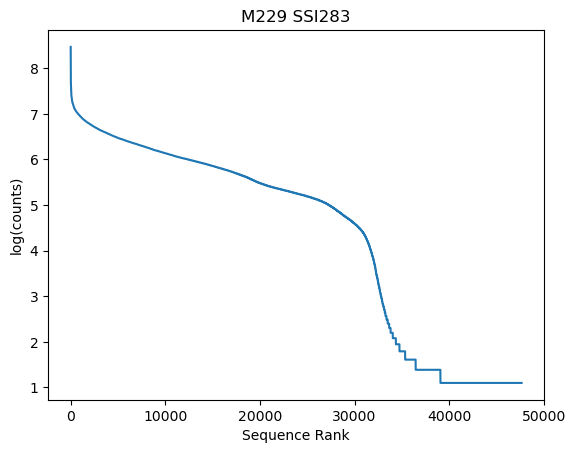

In [33]:
plotdf = outcdf[outcdf.counts > 2]
#plotdf['logcounts'] = np.log(plotdf.counts)
#  y axis. log of counts. 
#. x axis.  'sequence rank'

ax = sns.lineplot(data=plotdf, x= plotdf.index, y = 'logcounts')
ax.set(xlabel='Sequence Rank',
      ylabel='log(counts)',
      title = 'M229 SSI283')
plt.show()

In [30]:
#graph = sns.FacetGrid(alldf, col = 'bc_label', hue='counts', col_wrap = 4, row_order='bc_label')
#graph.map(sns.lineplot, y="counts")
#plt.show()

In [17]:
# use BC16  as example 
# need to trim again to 32 length!!

reals =[]
spikes =[]
lones =[]

alldfs = []

for bch in bcolist[:1]:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    
    outfile = trim_fasta(cp, bch.filename, length=32)
    seqdf = make_fasta_df(cp, outfile)
    df = make_counts_df(cp, seqdf, bc_label=bch.label)
    bch.dataframe = df
    print(f'{bch.label} {len(df)}')
    (spikedf, realdf, lonedf) = split_spike_real_lone_barcodes(cp, df)

    realcdf = make_counts_df(cp, realdf)
    spikecdf = make_counts_df(cp, spikedf)
    lonecdf = make_counts_df(cp, lonedf)    
    
    print(realdf)
    
    acrealdf = align_and_collapse(cp, realdf, dirname, base, 'real')
    acspikedf = align_and_collapse(cp, spikedf, dirname, base, 'spike')
    aclonedf = align_and_collapse(cp, lonedf, dirname, base, 'lone')
    
    acrealdf['type'] = 'real'
    acspikedf['type'] = 'spike'
    aclonedf['type'] = 'lone'
    
    outdf = merge_dfs([ acrealdf, acspikedf, aclonedf ])
    outdf['bc_label'] = base
    outdf.sort_values(by = ['type', 'counts'], ascending = [True, False], inplace=True)
    outdf.reset_index(drop=True, inplace=True)
    alldfs.append(outdf)
    
alldfs
    
    #print(reals[0])

2023-04-17 19:28:02,175 (UTC) [ INFO ] core.py:352 root.trim_fasta(): wrote 7342 to /Users/jhover/project/mapseq/M205jupout/BC1.32.fasta
2023-04-17 19:28:02,243 (UTC) [ INFO ] core.py:327 root.make_fasta_df(): kept 7342 sequences out of 7342
2023-04-17 19:28:02,251 (UTC) [ INFO ] core.py:301 root.make_counts_df():                               sequence
0     TAAATGGACAACATCGTCCTAGGAATGAGTTC
1     ACCTGATGGCTGCTTACTTACTGCCGTCAGTC
2     GCCTAGGAACCACTAAGTGCGTAACGTCAGTC
3     ATTTTTACTCGCTCGAGAAGCAAACGTCAGTC
4     CCGTTGGGCGTAGTGGAACAAGAATGATGTTT
...                                ...
7337  TCAACAGCGTTTTGTGTACTAGCGTCAGTCTC
7338  GATATGTATCGCTGCACTCCCAGTCGTCAGTC
7339  AGGCTTGTCGTGCTAAGTCGCGGTTGGCGCTC
7340  CTTGGATTTAATTGCTAATTTCTTCGTCAGTC
7341  AGCCGGATAATAGTTGTTTGGTGCCGTCAGTC

[7342 rows x 1 columns]
2023-04-17 19:28:02,272 (UTC) [ INFO ] core.py:415 root.split_spike_real_lone_barcodes(): initial=3615 spikeins=2639 real=787 lone=94
2023-04-17 19:28:02,273 (UTC) [ INFO ] core.py:301 root.m

BC1 3615
                             sequence  counts bc_label
0    TAAATGGACAACATCGTCCTAGGAATGAGTTC     257      BC1
1    TGTGAGTATCAATTTGTCCGTTTTCATCCACT      78      BC1
2    GCCGTTAAATTACTAGTAACCAGCCCGTCTCC      76      BC1
3    CAATGAGCTTGGGCAAGGGGGCGGGAGTCACT      72      BC1
4    GCTCTCGAGACGTTGTCATAGTATAGGCCCCC      68      BC1
..                                ...     ...      ...
782  TGACGTGGGTATTGTACGTTTGAGGGGCCCTC       1      BC1
783  AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC       1      BC1
784  TGTTCAGTCGAATAACTTTTTTACTTCTGTCT       1      BC1
785  GGGTTTTGGTCGTGGATGGGTGTGCAATCACC       1      BC1
786  TAGGTGTCTTTTTATAGGCTGTTAAGGAGTTC       1      BC1

[787 rows x 3 columns]


2023-04-17 19:28:02,581 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-04-17 19:28:02,795 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.
2023-04-17 19:28:02,797 (UTC) [ INFO ] core.py:135 root.align_and_collapse(): handle bowtie align file: /Users/jhover/project/mapseq/M205jupout/BC1.real.bowtie
2023-04-17 19:28:02,813 (UTC) [ INFO ] core.py:230 root.get_components(): getting connected components from edgelist len=845
2023-04-17 19:28:02,817 (UTC) [ INFO ] core.py:235 root.get_components(): 758 components.
2023-04-17 19:28:02,818 (UTC) [ INFO ] core.py:141 root.align_and_collapse(): countdf columns are Index(['sequence', 'counts', 'bc_label'], dtype='object')
2023-04-17 19:28:02,819 (UTC) [ INFO ] core.py:189 root.collapse_counts_df(): collapsing countsdf len=787 w/ 758 components.
2023-04-17 19:28:04,146 (UTC) [ INFO ] core.py:216 root.collapse_counts_df(): original len=787 collapsed len=758
2023-04-17 19:28:04,149 (UTC) [ INFO ] core.py:374 root.

[                              sequence  counts bc_label   type
 0     TGTATATCCGGGCTTGAACCGTCAGTCTCGGA       3      BC1   lone
 1     TCGCGACTTCGCGCTCAGAATGGGAGGTATAG       3      BC1   lone
 2     GATCGCTATCTGTGTGTGTATAGCTCCGTCAG       3      BC1   lone
 3     GGGGATGTAAGTAAATTCGAGGCGACGGCTGG       2      BC1   lone
 4     ATCTATCAGTTCCCGCTGGCAACGCGTAATGA       2      BC1   lone
 ...                                ...     ...      ...    ...
 1384  GTTGAGAAGCTACTACGGTACAAGCGTCAGTC       2      BC1  spike
 1385  AGTTGGTTATGTCTCACATAGTAACGTCAGTC       2      BC1  spike
 1386  ATGCGTATTTCGCATTTGGAACAGCGTCAGTC       2      BC1  spike
 1387  CTTGCATTTTACAGCTTTCTGGACCGTCAGTC       2      BC1  spike
 1388  AGTGTGCTTTATATGTGTTTGACCCGTCAGTC       2      BC1  spike
 
 [1389 rows x 4 columns]]

In [18]:
bch = bcolist[3]
print(bch.label)
base = 'BC3'
aligner = cp.get('bcfasta','tool')
of = os.path.join(outdir , f'{base}.real.seq.fasta')
logging.debug(f'make fasta for {aligner} = {of}') 
seqfasta = write_fasta_from_df(cp, realdf, outfile=of)
of = os.path.join(outdir , f'{base}.real.{aligner}')
afile = run_bowtie(cp, seqfasta, of, tool=aligner )  
btdf = make_bowtie_df(afile)
btdf

2023-04-17 19:31:27,030 (UTC) [ INFO ] utils.py:632 root.dataframe_to_seqlist(): made list of 787 SeqRecords
2023-04-17 19:31:27,036 (UTC) [ INFO ] bowtie.py:35 root.run_bowtie(): running allxall bowtie on /Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta -> /Users/jhover/project/mapseq/M205jupout/BC3.real.bowtie
2023-04-17 19:31:27,037 (UTC) [ INFO ] bowtie.py:60 root.run_bowtie(): running ['bowtie-build', '/Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta', '/Users/jhover/project/mapseq/M205jupout/indexes/BC3.real.seq']


BC4


2023-04-17 19:31:27,250 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-04-17 19:31:27,472 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.


,name_read,strand,name_align,offset,seq,quals,ceil,mm_desc
0,0,+,0,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
1,0,+,391,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,13:A>T
2,1,+,1,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
3,1,+,694,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,6:C>T
4,2,+,2,0,GCCGTTAAATTACTAGTAACCAGCCCGTCTCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
...,...,...,...,...,...,...,...,...
840,783,+,783,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
841,783,+,47,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,11:G>A
842,784,+,784,0,TGTTCAGTCGAATAACTTTTTTACTTCTGTCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
843,785,+,785,0,GGGTTTTGGTCGTGGATGGGTGTGCAATCACC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN


In [19]:
cp = get_default_config()
allfiles = [
'/Users/jhover/project/mapseq/M205testout/BC1.all.tsv','/Users/jhover/project/mapseq/M205testout/BC21.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC10.all.tsv','/Users/jhover/project/mapseq/M205testout/BC22.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC11.all.tsv','/Users/jhover/project/mapseq/M205testout/BC23.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC12.all.tsv','/Users/jhover/project/mapseq/M205testout/BC24.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC13.all.tsv','/Users/jhover/project/mapseq/M205testout/BC25.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC14.all.tsv','/Users/jhover/project/mapseq/M205testout/BC26.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC15.all.tsv','/Users/jhover/project/mapseq/M205testout/BC3.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC16.all.tsv','/Users/jhover/project/mapseq/M205testout/BC4.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC17.all.tsv','/Users/jhover/project/mapseq/M205testout/BC5.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC18.all.tsv','/Users/jhover/project/mapseq/M205testout/BC6.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC19.all.tsv','/Users/jhover/project/mapseq/M205testout/BC7.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC2.all.tsv','/Users/jhover/project/mapseq/M205testout/BC8.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC20.all.tsv','/Users/jhover/project/mapseq/M205testout/BC9.all.tsv'    
]
bcm, sbcm = process_merge_targets(cp, allfiles, outdir=None)
bcm

2023-04-17 19:31:34,962 (UTC) [ INFO ] core.py:700 root.process_merge_targets(): ['/Users/jhover/project/mapseq/M205testout/BC1.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC21.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC10.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC22.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC11.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC23.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC12.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC24.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC13.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC25.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC14.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC26.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC15.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC3.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC16.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC4.all.tsv', '/Users/j

bc_label,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,...,BC16,BC17,BC18,BC19,BC20,BC21,BC22,BC23,BC24,BC25
0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
1,0,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,51,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40172,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0
40173,0,0,0,0,0,0,0,0,0,0,...,13,0,0,0,0,0,0,0,0,0
40174,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0
